### Basic Introduction about LeNet

LeNet-5, from the paper Gradient-Based Learning Applied to Document Recognition, is a very efficient convolutional neural network for handwritten character recognition.


<a href="http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf" target="_blank">Paper: <u>Gradient-Based Learning Applied to Document Recognition</u></a>

**Authors**: Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner

**Published in**: Proceedings of the IEEE (1998)


The structure of vanilla LeNet is explained in detail in the MNIST implementation. 

In our below LeNet architecture, I have taken the activation function as 'Relu' instead of 'tanh' since it provides more optimal results.

For more details on structure of this LeNet for Dog Cat classification, kindly refer to model summary below.

### Code Implementation

In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./dog_cat_input"))

['test1', 'train']


In [17]:
IMAGE_WIDTH=128  # The Conv2d function requires same dimensions for all the data samples
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [5]:
# preparing the training data

filenames = os.listdir("./dog_cat_input/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


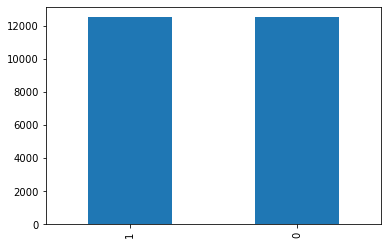

In [9]:
df["category"].value_counts().plot.bar()

In [10]:
df.shape

(25000, 2)

So out of 25000 train data, we have 12500 dogs images and 12500 cats images. The data is balanced.

Text(0.5, 1.0, 'cat.3770.jpg')

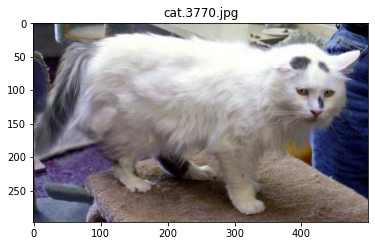

In [16]:
# Let us preview a sample image

preview = random.choice(filenames)
img = load_img("./dog_cat_input/train/train/"+preview)
plt.imshow(img)
plt.title(preview)

We can preview a lovely cat here.

In [20]:
# let us build our LeNet model 

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization


model = Sequential()



model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))


model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(120, activation='relu'))


model.add(Dense(84, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.metrics.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 124, 124, 6)       456       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 58, 58, 16)        2416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 13456)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               1614840   
_________________________________________________________________
dense_8 (Dense)              (None, 84)               

In [60]:
# We are choosing to reduce learning rate if no improvement is seen for 2 epochs.

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [61]:
callbacks = [learning_rate_reduction]

To correctly identify every type of dog or cat image, we need to augment our train data. Thus, it will capture most of the possible variations (like a dog lying upwards).  

ImageDataGenerator generates batches of tensor image data with real-time data augmentation. A good desciption can be found at https://keras.io/api/preprocessing/image/

In [21]:
# Because we will use image genaretor with class_mode="categorical", 
# We need to convert column category into string. 
# Then ImageGenerator will convert it one-hot encoding which is good for our classification.
# So we will convert 1 to dog and 0 to cat.

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [22]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [23]:
train_df.head()

,filename,category
0,dog.8479.jpg,dog
1,dog.876.jpg,dog
2,cat.10915.jpg,cat
3,dog.10127.jpg,dog
4,cat.11377.jpg,cat


In [24]:
validate_df.head()

,filename,category
0,cat.493.jpg,cat
1,dog.9112.jpg,dog
2,cat.745.jpg,cat
3,dog.11022.jpg,dog
4,dog.11363.jpg,dog


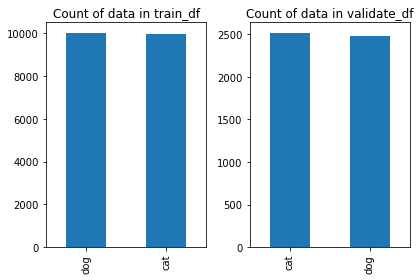

In [43]:
plt.subplot(1,2,1)
train_df['category'].value_counts().plot.bar()
plt.title("Count of data in train_df")

plt.subplot(1,2,2)
validate_df['category'].value_counts().plot.bar()
plt.title("Count of data in validate_df")

plt.tight_layout()

The data seems pretty balanced in both the sets.

In [30]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=128

print("Total data to train is {} and the total data to validate is {} with a batch size of {}."
      .format(total_train, total_validate, batch_size))

Total data to train is 20000 and the total data to validate is 5000 with a batch size of 128.


#### Training Data Generator

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dog_cat_input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


#### Validation Data Generator

In [52]:
validation_datagen = ImageDataGenerator(rescale=1./255) # The ImageDataGenerator class can be used to rescale pixel values from
                                                        # the range of 0-255 to the range 0-1 preferred for neural networks.

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dog_cat_input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [40]:
# Let us check if our ImageDataGenerator is working correctly

example_df = train_df.sample(n=1)#.reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dog_cat_input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


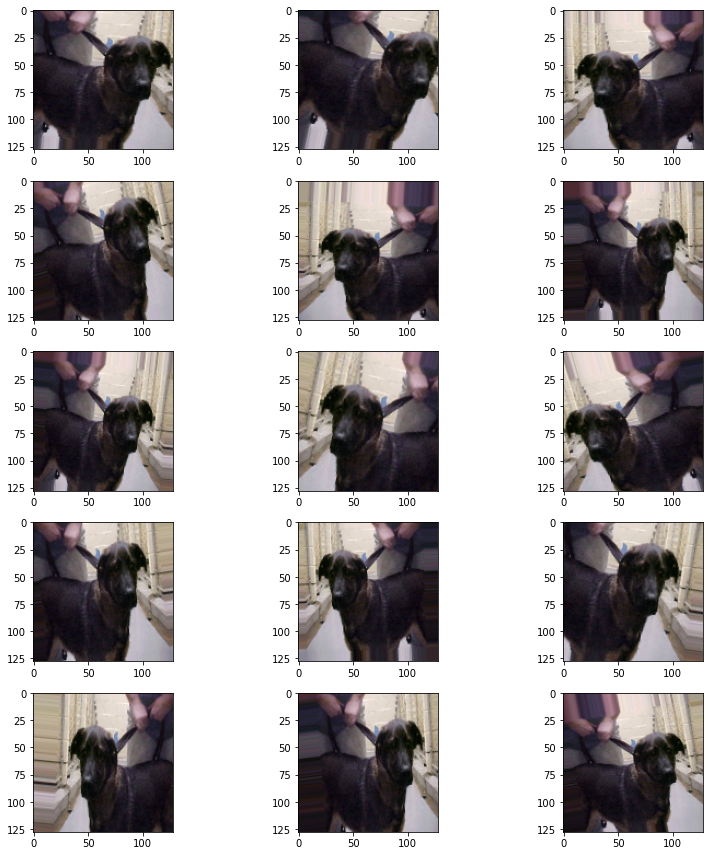

In [49]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

Our ImageDataGenerator seems to work fine as it is giving results accordingly.

In [ ]:
# Let us train and validate the model.

In [67]:
import math

In [69]:
# Viualize the epochs = 50, steps_per epoch = 156 and batches = 128 as as of the step out of 156 step per epoch has 
# tensors of 128 batch size. i.e 1st step of 1st epoch has 128 batches, 2nd step of 1st epoch has 128 bacthes.......
# ... 156th step of 1st epoch has 128 batches i.e in total 156 * (128) = 20,000 training data is being fed in 1 epoch


history = model.fit_generator(
    train_generator, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=math.ceil(total_validate//batch_size),
    steps_per_epoch=math.ceil(total_train//batch_size),
    callbacks=callbacks
)


Epoch 1/50
156/156 [==============================] - 1023s 7s/step - loss: 0.6320 - accuracy: 0.6464 - val_loss: 0.6261 - val_accuracy: 0.6717
Epoch 2/50
156/156 [==============================] - 825s 5s/step - loss: 0.6037 - accuracy: 0.6741 - val_loss: 0.5220 - val_accuracy: 0.7071
Epoch 3/50
156/156 [==============================] - 803s 5s/step - loss: 0.5760 - accuracy: 0.6987 - val_loss: 0.5040 - val_accuracy: 0.7268
Epoch 4/50
156/156 [==============================] - 897s 6s/step - loss: 0.5418 - accuracy: 0.7239 - val_loss: 0.5109 - val_accuracy: 0.7504
Epoch 5/50
156/156 [==============================] - 709s 5s/step - loss: 0.5302 - accuracy: 0.7352 - val_loss: 0.4427 - val_accuracy: 0.7518
Epoch 6/50
156/156 [==============================] - 766s 5s/step - loss: 0.5115 - accuracy: 0.7468 - val_loss: 0.4248 - val_accuracy: 0.7674
Epoch 7/50
156/156 [==============================] - 640s 4s/step - loss: 0.4959 - accuracy: 0.7559 - val_loss: 0.4140 - val_accuracy: 0.781

c:\users\tanvi\anaconda3\envs\lenetenv\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 85 could not be retrieved. It could be because a worker has died.
  UserWarning)


156/156 [==============================] - 933s 6s/step - loss: 0.3909 - accuracy: 0.8223 - val_loss: 0.4005 - val_accuracy: 0.8317
Epoch 45/50
156/156 [==============================] - 724s 5s/step - loss: 0.3883 - accuracy: 0.8255 - val_loss: 0.4043 - val_accuracy: 0.8274
Epoch 46/50
156/156 [==============================] - 754s 5s/step - loss: 0.3826 - accuracy: 0.8247 - val_loss: 0.3701 - val_accuracy: 0.8266
Epoch 47/50
156/156 [==============================] - 653s 4s/step - loss: 0.3857 - accuracy: 0.8261 - val_loss: 0.3775 - val_accuracy: 0.8296
Epoch 48/50
156/156 [==============================] - 576s 4s/step - loss: 0.3863 - accuracy: 0.8269 - val_loss: 0.3086 - val_accuracy: 0.8307
Epoch 49/50
156/156 [==============================] - 857s 5s/step - loss: 0.3833 - accuracy: 0.8260 - val_loss: 0.2406 - val_accuracy: 0.8272
Epoch 50/50
156/156 [==============================] - 668s 4s/step - loss: 0.3934 - accuracy: 0.8215 - val_loss: 0.4414 - val_accuracy: 0.8317


In [71]:
model.save_weights("LeNet_dog_cat_model.h5")

#### Visualize training rate and validation rate

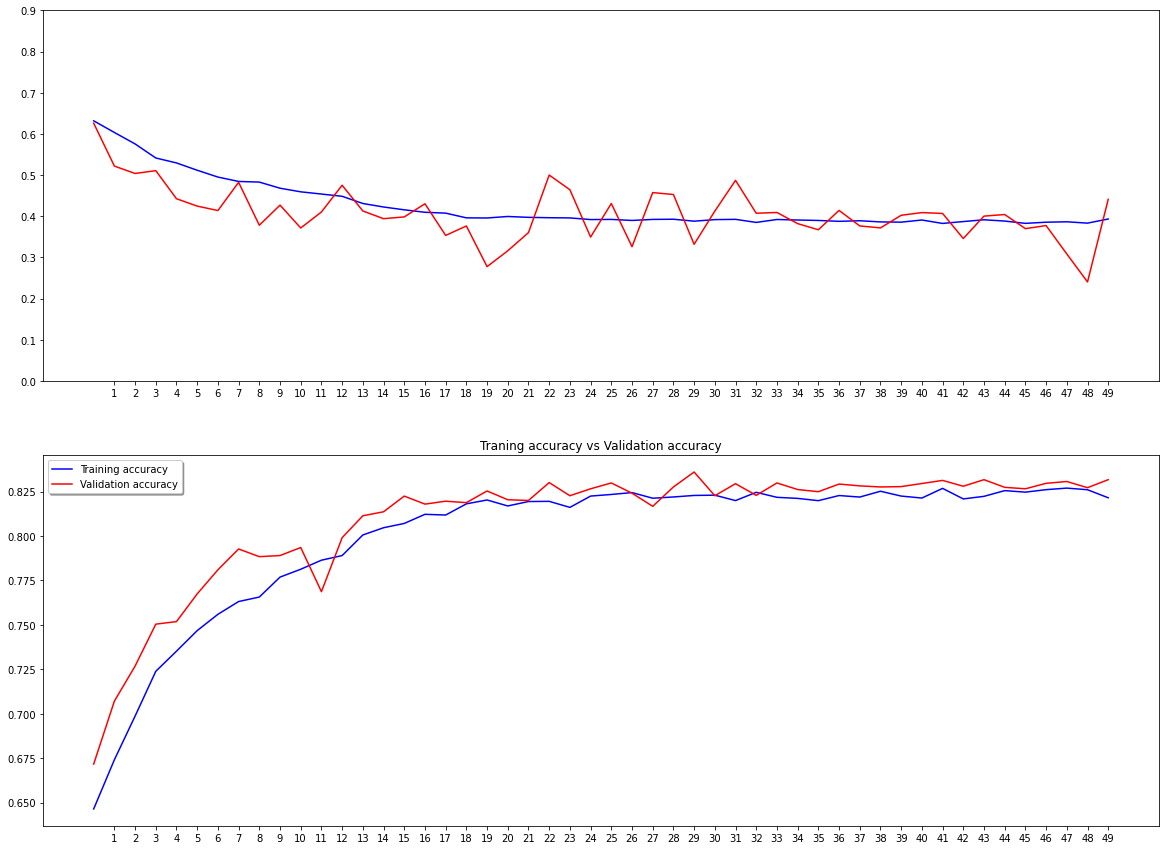

In [83]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,15))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, 50, 1)) # 50 is the number of epochs
ax1.set_yticks(np.arange(0, 1, 0.1))
plt.title("Traning loss vs Validation loss")

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1)) # 50 is the number of epochs
plt.title("Traning accuracy vs Validation accuracy")

legend = plt.legend(loc='best', shadow=True)
#plt.tight_layout()
plt.show()

### Predict

In [86]:
# Preparing test data

test_filenames = os.listdir("./dog_cat_input/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

12500

In [87]:
# Creating testing generator

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dog_cat_input/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [88]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [90]:
predict

array([[0.03218039, 0.9678196 ],
       [0.94270486, 0.05729512],
       [0.81339395, 0.18660605],
       ...,
       [0.04245557, 0.9575444 ],
       [0.98708874, 0.01291126],
       [0.18958741, 0.8104126 ]], dtype=float32)

In [89]:
# Since we have categoral classication, the prediction will come with probability of each category from which we can 
# select the one with highest probablity

In [91]:
test_df['category'] = np.argmax(predict, axis=-1)

In [92]:
# We will convert the predict category back into our generator classes by using train_generator.class_indices.

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)


In [93]:
test_df["category"]

0        dog
1        cat
2        cat
3        dog
4        dog
        ... 
12495    cat
12496    dog
12497    dog
12498    cat
12499    dog
Name: category, Length: 12500, dtype: object

In [ ]:
# {1: 'dog', 0: 'cat'} as we did in training.
# The below step will be useful when we want to check the accuracy

# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

Text(0.5, 1.0, 'Stats of predicted test_data')

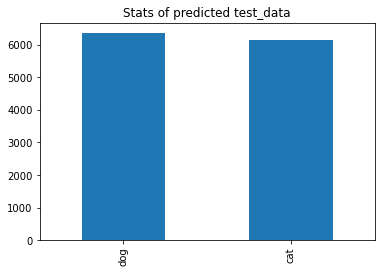

In [95]:
# Visualize the results

test_df['category'].value_counts().plot.bar()
plt.title("Stats of predicted test_data")

In [96]:
# Since we do not have the labels for test data, we cannot calculate the accuracy. However,let us check some of the samples.

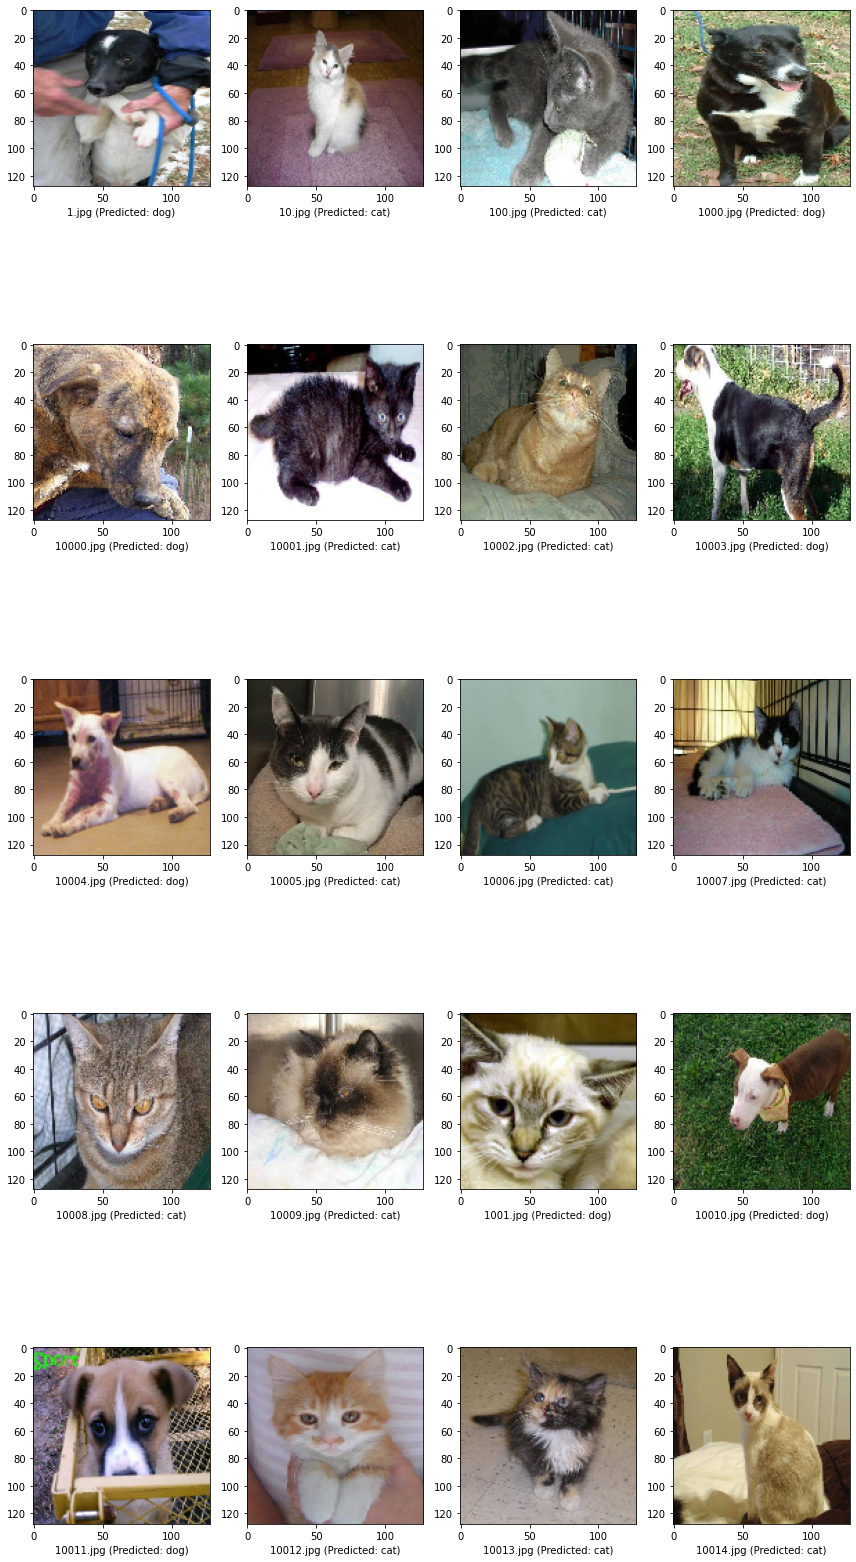

In [98]:
sample_test = test_df.head(20)
# sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dog_cat_input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(5, 4, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' (' + "Predicted: {}".format(category) + ')' )
plt.tight_layout()
plt.show()